# **AstrID:**  *model training*

### Importing Necessary Libraries and Modules

In this section, we import the necessary libraries and modules required for training our model. These include:

- **TensorFlow and Keras**: For building and training the neural network.
- **NumPy**: For numerical operations and handling arrays.
- **Matplotlib**: For plotting and visualizing data.
- **Custom Functions**: 
    - [`unet`](models/unet.py): For the `unet_model`.
    - [`dataGathering`](dataGathering.ipynb): to handle data extraction.
    - [`imageProcessing`](imageProcessing.py): for image modification to fit model requirements.
    - [`log`](log.py): for `write_to_log` functionality.

The comments in the code provide additional details about each import.

In [1]:
# Import tensorflow and keras
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.preprocessing import image
from keras.initializers import he_uniform
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.optimizers import Adam
from sklearn.utils import class_weight

# Import other necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import getpass
import pandas as pd
from astropy.io import fits

# Import custom model function
from models.unet import unet_model

# Import custom functions to import the dataset
from dataGathering import importDataset

# Import custom functions to preprocess Image and Pixel Mask arrays
from imageProcessing import normalizeImages, stackImages, stackMasks, preprocessImage

# Import custom logging function
from log import write_to_log


2024-11-22 17:58:07.635035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 17:58:08.285889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-11-22 17:58:10.572048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 17:58:10.596182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 17:58:10.596257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available")
    
    # Clear GPU memory
    K.clear_session()
    tf.config.experimental.reset_memory_stats('GPU:0')

GPU is available


2024-11-22 17:58:10.611139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 17:58:10.611364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 17:58:10.611457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 17:58:10.808598: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 17:58:10.808740: I tensorflow/compile

### Initializing Lists for the Dataset

In this section, we initialize the lists that will be used to store the dataset. These lists will hold the images, masks, star data, WCS data, and FITS file names, which are essential for training and validating the model.



In [4]:
# Initialize lists to store the dataset
images = []
masks = []
star_data = []
wcs_data = []
fits_files = []

In [5]:
# Define the path to and name of the dataset ('data' for training)
dataset_path = 'data/fits/'
dataset_name = 'data'

### Understanding the Imported Dataset

After using the `importDataset` function, we obtain five lists: 

`images`, `masks`, `stars_in_image`, `wcs_data`, and `fits_files`. Each of these lists plays a crucial role in preparing our dataset for training and validating the model.

#### Resulting Lists

1. **Images (`images`)**: This list contains 2D arrays representing the pixel values of sky regions, used as input data for the model.
2. **Masks (`masks`)**: This list contains 2D arrays indicating the presence or absence of stars, serving as ground truth labels for training.
3. **Stars In Image (`stars_in_image`)**: This list contains the coordinate information for each star present in the image.
4. **WCS Data (`wcs_data`)**: This list contains the World Coordinate System (WCS) data for each image, which is used for mapping pixel coordinates to sky coordinates.
5. **FITS Files (`fits_files`)**: This list contains the filenames of the FITS files in the dataset, useful for tracking and referencing the source data.

By importing and understanding these lists, we ensure that our dataset is properly prepared for training and validating the model, enabling it to learn from the input images and corresponding masks.

In [6]:
# Import the dataset
images, masks, stars_in_image, wcs_data, fits_files = importDataset(dataset_path=dataset_path, dataset_name=dataset_name)

# Display the shapes of the resulting lists
print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")
print(f"Number of star data entries: {len(stars_in_image)}")
print(f"Number of WCS data entries: {len(wcs_data)}")
print(f"Number of FITS files: {len(fits_files)}")

Number of stars in catalog query:  442
data47.fits added to dataset
Number of stars in catalog query:  649
data8.fits added to dataset
Number of stars in catalog query:  691
data93.fits added to dataset
Number of stars in catalog query:  701
data202.fits added to dataset


Number of stars in catalog query:  729
data79.fits added to dataset
Number of stars in catalog query:  1183
data116.fits added to dataset
Number of stars in catalog query:  2970
data187.fits added to dataset
Number of stars in catalog query:  1571
data100.fits added to dataset
Number of stars in catalog query:  618
data10.fits added to dataset
Number of stars in catalog query:  7779
data91.fits added to dataset
Number of stars in catalog query:  1758
data34.fits added to dataset
Number of stars in catalog query:  1112
data117.fits added to dataset
Number of stars in catalog query:  2549
data148.fits added to dataset
Number of stars in catalog query:  1525
data107.fits added to dataset
Number of stars in catalog query:  4456
data38.fits added to dataset
Number of stars in catalog query:  8036
data134.fits added to dataset
Number of stars in catalog query:  2262
data238.fits added to dataset
Number of stars in catalog query:  616
data136.fits added to dataset
Number of stars in catalog q

By importing and understanding these lists, we ensure that our dataset is properly prepared for training and validating the model, enabling it to learn from the input images and corresponding masks.

*We delay splitting into training and validatiion sets, as we will use parameters from the model hyperparamaters to do so after they are defined below.*

### Preparing Images and Masks for the Model

To ensure our images and masks are in the correct format for training the model, we need to perform some transformations. Our model expects the images to have three channels, similar to standard RGB images, and the masks to have a single channel. Here’s how we achieve this:

**Convert Images to 3-Channel Format:** Our images are currently in the shape `(512, 512)`, but the model requires them to be in the shape `(512, 512, 3)`. To convert the single-channel images into 3-channel images, we stack the images along the last axis three times. This transformation is necessary because the model typically expects 3-channel input images.

**Convert Masks to Single-Channel Format:** For the masks, the model expects them to be in the shape `(512, 512, 1)`. We expand the masks along the last axis to add a new dimension, ensuring they have the correct shape.

**Convert to NumPy Arrays:** Both the images and masks need to be converted to NumPy arrays, as this is the desired format for the training model. This conversion ensures that the data is in the correct format for training.

Below, we perform these conversions to ensure the data is in the correct format for training.



In [7]:
stacked_images = stackImages(images)
stacked_masks = stackMasks(masks)

By performing these transformations, we ensure that our images and masks are in the correct format for training the model. The `stacked_images` array will have a shape of `(250, 512, 512, 3)`, indicating that we have 250 images, each with a size of 512x512 pixels and 3 channels. The `stacked_masks` array will have a shape of `(250, 512, 512, 1)`, indicating that we have 250 masks, each with a size of 512x512 pixels and a single channel.

### Normalize the Images

To standardize the pixel values in our images, we need to normalize them to a common range.
We will use min-max normalization to scale the pixel values to a range between 0.0 and 1.0.

In [8]:
# normalized_images = normalizeImages(stacked_images)

### Building the U-Net Model

We define and compile the U-Net model using the specified hyperparameters. The U-Net architecture is well-suited for image segmentation tasks. We use the Adam optimizer and binary cross-entropy loss function for training.

In [9]:
# Define hyperparameters
hyperparameters = {
    'input_shape': (512, 512, 3),
    'filters': [64, 128, 256, 512, 1024],
    'kernel_size': (3, 3),
    'activation': 'relu',
    # 'activation': 'leaky_relu',
    'padding': 'same',
    'initializer': he_uniform,
    'learning_rate': 0.00001,
    'optimizer': 'Adam(learning_rate=learning_rate)',
    'loss': 'binary_crossentropy',
    'weights' : {0 : 1.0, 1 : 5.5},
    'metrics': ['accuracy'],
    'epochs': 1000,
    'batch_size': 4,
    'early_stopping_patience': 10,
    'test_size': 0.2,
    'random_state': 0,
    'seed': 42
}

# Create the optimizer using the stored learning rate
optimizer = Adam(learning_rate=hyperparameters['learning_rate'])

# Create and compile the model using hyperparameters
model = unet_model(
    input_shape=hyperparameters['input_shape'],
    filters=hyperparameters['filters'],
    kernel_size=hyperparameters['kernel_size'],
    activation=hyperparameters['activation'],
    padding=hyperparameters['padding'],
    initializer=hyperparameters['initializer']
)
model.compile(
    optimizer=optimizer,
    loss=hyperparameters['loss'],
    metrics=hyperparameters['metrics']
)

### Splitting the Stacked Images and Masks

In this section, we split the stacked images and masks into training and validation sets using the specified hyperparameters. This step is crucial for evaluating the model's performance on unseen data and preventing overfitting.

**Hyperparameters**:
We use the following hyperparameters to control the data splitting process:
- `test_size`: The proportion of the dataset to include in the validation set.
- `random_state`: A seed value to ensure reproducibility of the data splitting.

**Splitting the Data**: We use the `train_test_split` function from the `sklearn.model_selection` module to split the images and masks into training and validation sets. The function randomly shuffles the data and splits it according to the specified `test_size`.

By splitting the data into training and validation sets, we ensure that the model is trained on one portion of the data and validated on another, helping us assess its generalization ability.

In [10]:
# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(stacked_images, stacked_masks, test_size=hyperparameters['test_size'], random_state=hyperparameters['random_state'])

# Show distribution of training and validation sets
print('Training images: ', train_images.shape)
print('Training masks: ', train_masks.shape)
print('Validation images: ', val_images.shape)
print('Validation masks: ', val_masks.shape)

Training images:  (200, 512, 512, 3)
Training masks:  (200, 512, 512, 1)
Validation images:  (50, 512, 512, 3)
Validation masks:  (50, 512, 512, 1)


### Training the Model

We train the U-Net model using the training dataset. Early stopping is implemented to prevent overfitting. The training process is monitored using the validation dataset.

In [11]:
# Implement Early stopping to cut useless epochs
early_stopping = EarlyStopping(
    monitor='val_loss',  # or another metric like 'val_accuracy'
    patience=hyperparameters['early_stopping_patience'],         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restores the model to the best state after stopping
)


# Train the model
history = model.fit(
    train_images, train_masks, 
    validation_data=(val_images, val_masks), 
    epochs=hyperparameters['epochs'], 
    batch_size=hyperparameters['batch_size'],
    callbacks=[early_stopping],
    class_weight=hyperparameters['weights']
)

Epoch 1/1000


2024-11-22 17:58:52.468351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-22 17:58:53.668541: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc90f6d32b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-22 17:58:53.668619: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-11-22 17:58:53.726545: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-22 17:58:54.059816: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-11-22 17:58:55.211554: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.52GiB with freed_by_count=0. The call

50/50 [==============================] - 31s 291ms/step - loss: 74.8813 - accuracy: 0.9708 - val_loss: 13.8071 - val_accuracy: 0.9683
Epoch 2/1000
50/50 [==============================] - 12s 239ms/step - loss: 37.3367 - accuracy: 0.9641 - val_loss: 8.2001 - val_accuracy: 0.9835
Epoch 3/1000
50/50 [==============================] - 13s 262ms/step - loss: 32.2622 - accuracy: 0.9637 - val_loss: 8.7561 - val_accuracy: 0.9711
Epoch 4/1000
50/50 [==============================] - 12s 247ms/step - loss: 28.2514 - accuracy: 0.9641 - val_loss: 9.4417 - val_accuracy: 0.9569
Epoch 5/1000
50/50 [==============================] - 13s 263ms/step - loss: 25.5005 - accuracy: 0.9638 - val_loss: 6.0918 - val_accuracy: 0.9815
Epoch 6/1000
50/50 [==============================] - 13s 261ms/step - loss: 23.6722 - accuracy: 0.9629 - val_loss: 7.5371 - val_accuracy: 0.9604
Epoch 7/1000
50/50 [==============================] - 12s 239ms/step - loss: 21.7481 - accuracy: 0.9630 - val_loss: 5.5937 - val_accurac

#### Saving the Model

- We save the trained model using the `user` name, `training_size` and `datetime` to identify the filename.
- Model details including `history`, `parameters` and `saved_model_name` are written to log where they can be views in [`model_runs.txt`](log/model_runs.txt).

In [12]:
user = getpass.getuser()

# Save the model
saved_models_path = 'models/saved_models/'
training_size = str(len(train_images))
saved_model_name = datetime.datetime.now().strftime("%Y_%m_%d-%H%M_") + training_size + '_unet_model_' + user +  '.keras'
model.save(saved_models_path + saved_model_name)

#log model parameters, time, and user
write_to_log(history, hyperparameters, saved_model_name)

### Evaluating the Model

After training, we evaluate the model's performance on the validation dataset. We calculate the loss and accuracy metrics to assess the model's effectiveness.

In [13]:
# Show training loss and validation loss
print('Training loss: ', history.history['loss'][-1])
print('Validation loss: ', history.history['val_loss'][-1])

# Show training accuracy and validation accuracy
print('Training accuracy: ', history.history['accuracy'][-1])
print('Validation accuracy: ', history.history['val_accuracy'][-1])

Training loss:  8.89990234375
Validation loss:  3.355057954788208
Training accuracy:  0.9642408490180969
Validation accuracy:  0.9581549763679504


### Visualizing Results

We visualize the loss and accuracy along each epoch.

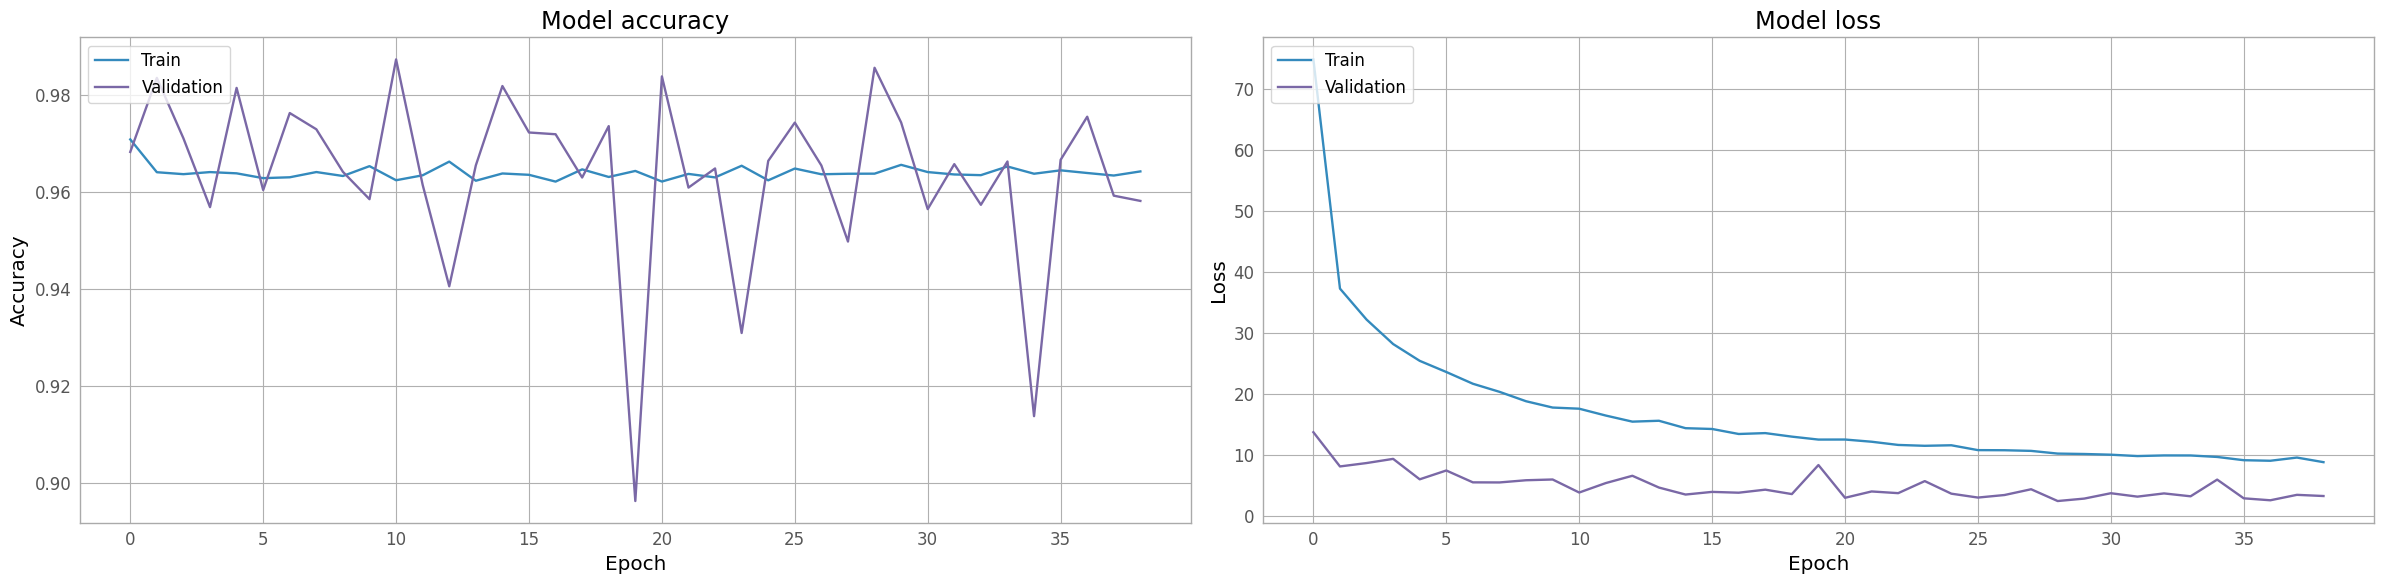

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.savefig('results/figures/plots/' + saved_model_name.removesuffix('_unet_model_' + user +  '.keras') + '_training_validation.png')
plt.show()

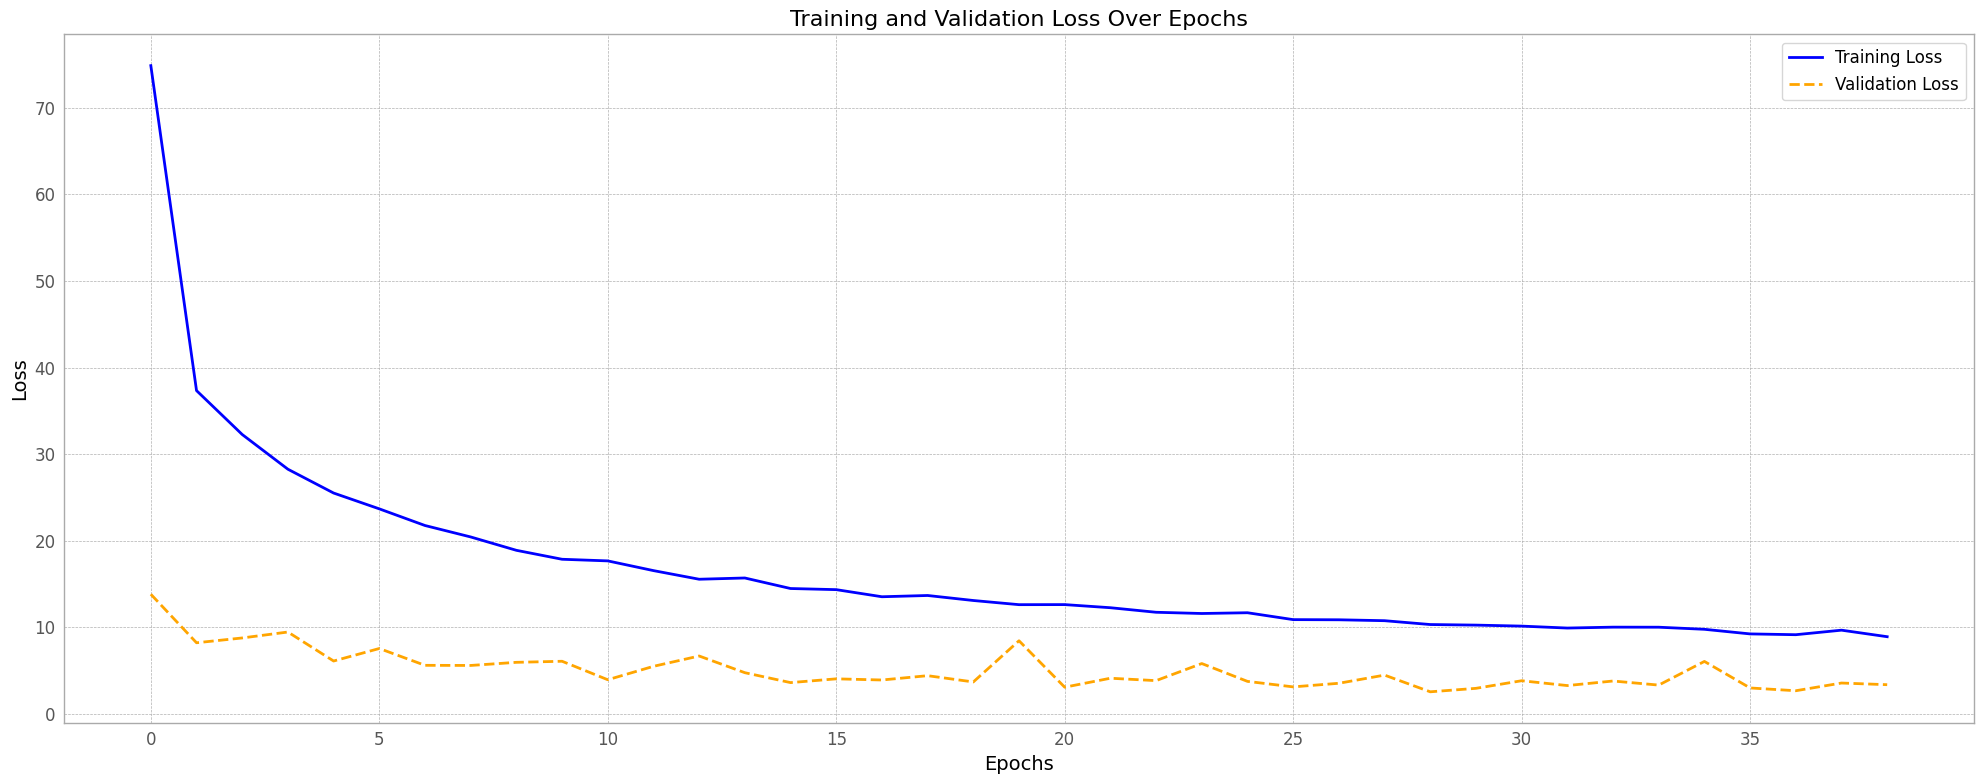

In [15]:
# Set a larger figure size
plt.figure(figsize=(20, 8))

# Plot the training and validation loss
plt.plot(history.history['loss'], color='blue', linestyle='-', linewidth=2, label='Training Loss')
plt.plot(history.history['val_loss'], color='orange', linestyle='--', linewidth=2, label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add legend to differentiate between training and validation loss
plt.legend(loc='best', fontsize=12)

# Show the plot
plt.tight_layout()
plt.savefig('results/figures/plots/' + saved_model_name.removesuffix('_unet_model_' + user +  '.keras') + '_training_validation_loss.png')
plt.show()
